# Framework

In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

Wybieram PyTorch oraz PytorchLightning(nie jestem pewny w jakim stopniu będę umiał go wykorzystać), ponieważ chcę lepiej poznać ten framework, porównać do bazowego PyTorcha z którego korzysta moja praca inżynierska.  
Dodatkowo zdaję sobię sprawę, że jest bardzo popularny i bardzo lubię kolor fioletowy.

# Data

In [2]:
train_data = datasets.FashionMNIST('./', download=True, train=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./', download=True, train=False, transform=transforms.ToTensor())

In [3]:
print(f'train size: {train_data.data.size()}\ntrain labels size: {train_data.train_labels.size()}')
print(f'test size: {test_data.data.size()}\ntest labels size: {test_data.test_labels.size()}')

train size: torch.Size([60000, 28, 28])
train labels size: torch.Size([60000])
test size: torch.Size([10000, 28, 28])
test labels size: torch.Size([10000])


/Users/denkov/anaconda3/envs/MRO/lib/python3.9/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/denkov/anaconda3/envs/MRO/lib/python3.9/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
def filter_set(data, labels):
    mask = (labels==3) + (labels==5)
    return data[mask].type(torch.float), torch.where(labels[mask]==3, 0, 1).type(torch.float)

(train_set, train_labels) = filter_set(train_data.train_data, train_data.train_labels)
(test_set, test_labels) = filter_set(test_data.test_data, test_data.test_labels)
print(f'new train size: {train_set.size()}\nnew train labels size: {train_labels.size()}')
print(f'new test size: {test_set.size()}\nnew test labels size: {test_labels.size()}')
classes = [train_data.classes[3], train_data.classes[5]]

new train size: torch.Size([12000, 28, 28])
new train labels size: torch.Size([12000])
new test size: torch.Size([2000, 28, 28])
new test labels size: torch.Size([2000])


/Users/denkov/anaconda3/envs/MRO/lib/python3.9/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/denkov/anaconda3/envs/MRO/lib/python3.9/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Do filtrowania wykorzystałem maski i działania na tensorach, dostępne bazowo we frameworku tensorflow.  
Przyrównanie tensora do jakiejś liczby tworzy nowy tensor wartości True/False, o wartości liczbowej 1 i 0 (w tej kolejności).  
Później możemy dodać 2 maski (po jednej dla klasy nr 3 i klasy nr 5 - niestety miałem problemy żeby przyrównać do 3 i 5 w jednej operacji).  
Zmieniam również klasę 3 na 0 i 5 na 1.  
Na koniec korzystam z faktu, że tensor zaindeksowany tensorem tej samej długości o wartościach True/False lub 1/0 zwraca nam tensor o indeksach, gdzie wartość była true lub 1.  

train:


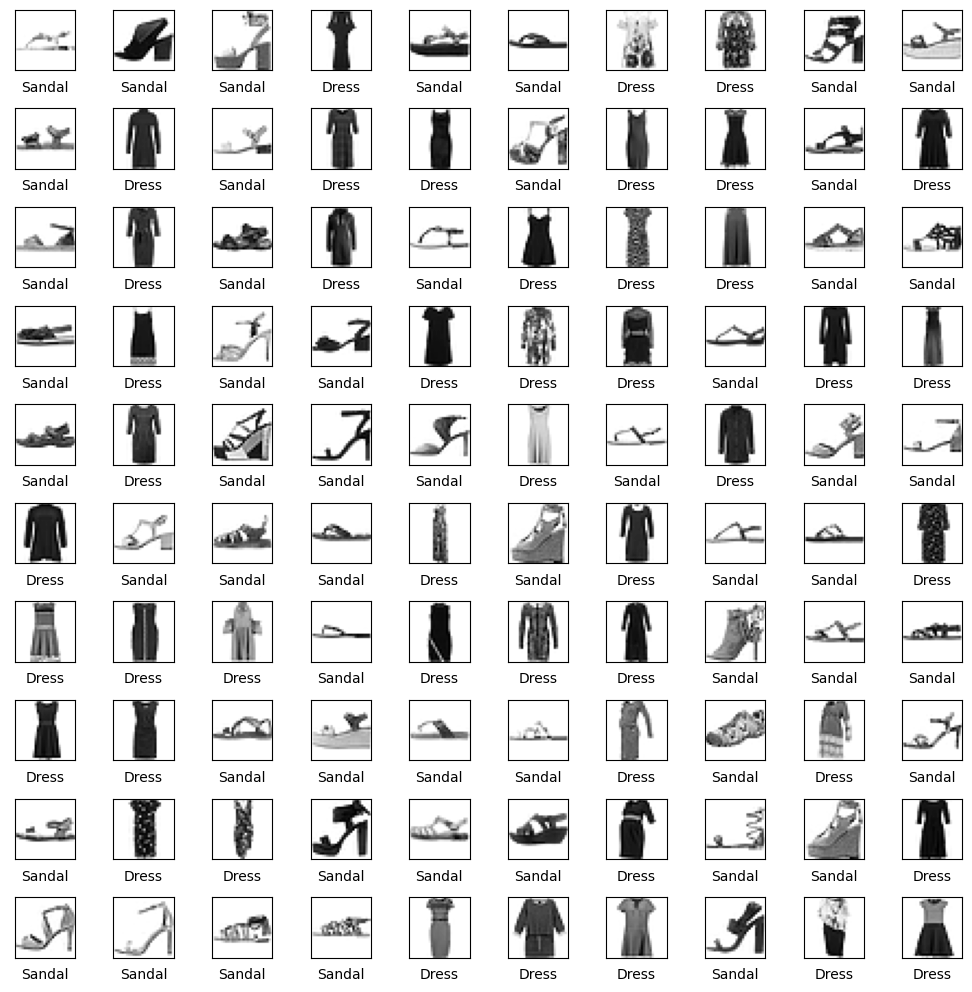

test:


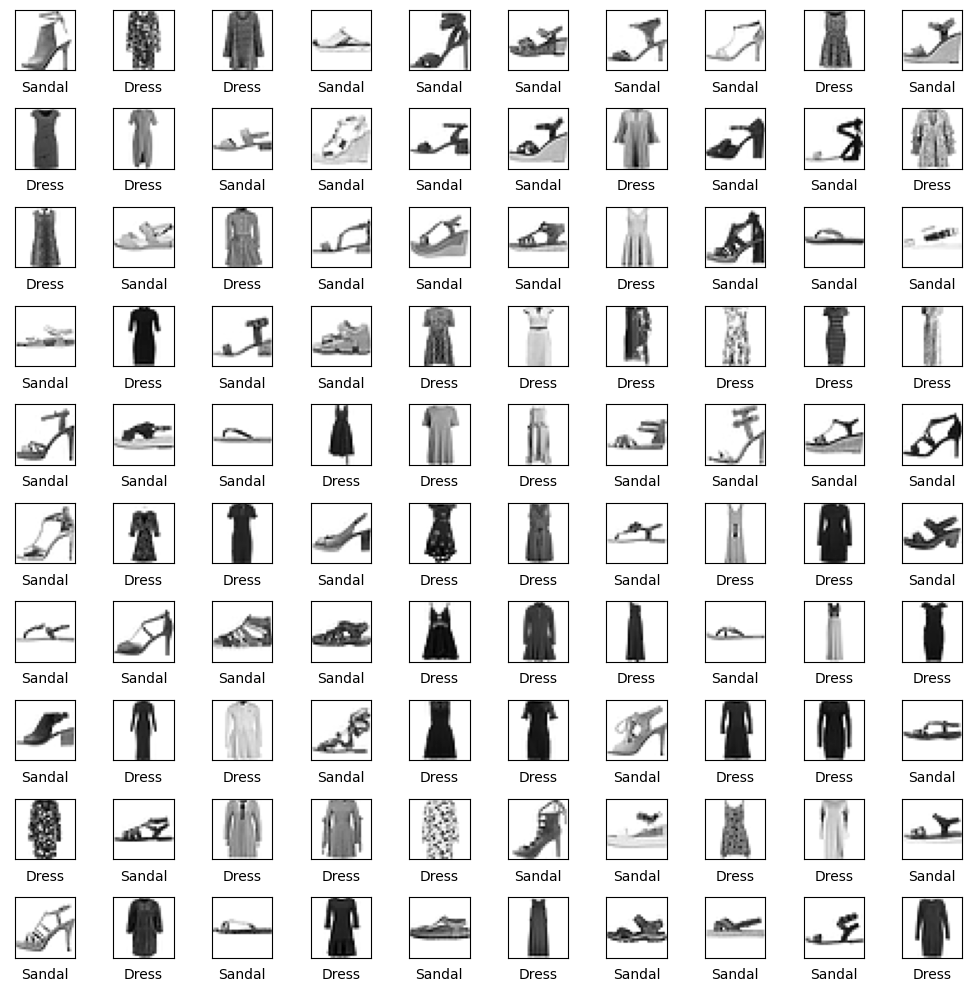

In [6]:
def print_data(data, labels=None, model=None, n=10):
    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n,n,i+1)
        plt.xticks([])
        plt.yticks([])
        rand = np.random.randint(0,len(data))
        if labels==None:
            plt.imshow(data[rand].unflatten(dim=0, sizes=(28,28)), cmap=plt.cm.binary)
            plt.xlabel(classes[model(data[rand])>0.5])
        else:
            plt.imshow(data[rand], cmap=plt.cm.binary)
            plt.xlabel(classes[labels[rand].item()>0.5])
    plt.tight_layout(pad=1)
    plt.show()

print('train:')
print_data(train_set, train_labels)
print('test:')
print_data(test_set, test_labels)

# Model

PyTorch Lightning oferuje LightningModule jako lepszą, lepiej zorganizowaną werjsę pytorch'owego nn.Module służącą do tworzenia modułów sieci neuronowej.  
Chcąc stworzyć własny model możemy odziedziczyć ww. klasę, dzięki czemu otrzymamy bardzo wiele funkcjonalości oraz możemy dokładnie zdecydować jak chcemy zdefiniować nasz model i jak powinnien się zachowywać.  
W naszym prostym przypadku możemy też po prostu stworzyć model, korzystając z gotowych klas, np. nn.Sequential, bez potrzeby tworzenia naszej klasy i dziedziczenia.

In [7]:
def flatten_and_normalise_set(set):
    flat=set.flatten(start_dim=1)
    return torch.nn.functional.normalize(flat)

train_set = flatten_and_normalise_set(train_set)
test_set = flatten_and_normalise_set(test_set)

Do "spłaszczczenia" macierzy obrazka do wektora wykorzystałem dostepną funkcję flatten, musiałem doprecyzować od którego wymiaru chcemy spłaszczać.  
Do normalizacji wykorzystałem dostepną funkcję normalise.
Etykiety klas zmieniłem już wcześniej, przy ograniczaniu naszego zbioru do tylko 2 klas. Wykorzystałem do tego funkcję where, która zmienia wartość wszędzie gdzie warunek jest spełniony, a w pozostałe miejsca wstawia drugą wartośc (przyrównuję do 3, wszędzie gdzie jest 3 wstaw 0, wszędzie indziej (ograniczyliśmy już klasy, więc pozostały tylko 5) wstaw 1).

Mógłbym również dodać flatten do modelu, ale niestety nie potrafię poradzić sobie z normalizacją danych wejściowych, więc postanowiłem, że lepiej oba wyciągnać do jednej funkcji.

In [8]:
print(f'has values <0 {(train_set<0).any()} {(test_set<0).any()}')
print(f'has values >1 {(train_set>1).any()} {(test_set>1).any()}')
# import pdb; pdb.set_trace()
print(f'shapes {train_set.size()} {test_set.size()}')

has values <0 False False
has values >1 False False
shapes torch.Size([12000, 784]) torch.Size([2000, 784])


Jeśli chodzi o debuggowanie na żywo, pytorch lightning dobrze współpracuje z pdb oraz oferuje 7 różnych loggerów, w tym tensorboard.

In [9]:
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 1),
    torch.nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=1, bias=True)
  (1): Sigmoid()
)


In [10]:
print("Any issues", (model(train_set)>1).any(), (model(train_set)<0).any())

Any issues tensor(False) tensor(False)


Wynik modelu ma sens, w sensie matematyczny, ponieważ wszystkie wartości mieszczą się w przedziale <0;1>

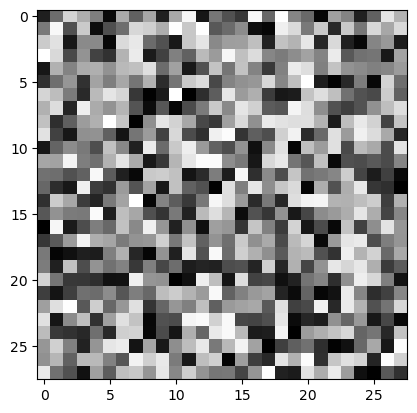

In [11]:
def show_weights(model):
    model[0].weight[0].size()
    lens = model[0].weight[0].unflatten(dim=0, sizes=(28,28))*255
    plt.imshow(lens.detach(), cmap=plt.cm.binary)
    plt.show()

show_weights(model)

Tak jak oczekiwaliśmy, dostaliśmy szum na "soczewce".

# edukacja

In [12]:
loss_fn = torch.nn.BCELoss()
lr=1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def fit(epochs=15):
    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(train_set).squeeze()
        loss = loss_fn(preds, train_labels)
        loss.backward()
        optimizer.step()

Aby nauczyć model wykorzystałem:  
- Funkcję straty opartej na binarnej entropii krzyżowej,  
- optymizatora stochastycznego spadku po gradiencie,  
- metody backwards, tensora zwróconego z funkcji starty, do wyznaczenia o ile wszystkie wagi powinny się zmienić  
- metody zero grad na optymizatorze, aby wyczyścić gradienty, zamiast dodawać je do poprzednich wartości
- oraz metody step, optymizatora służącej do zaaplikowania zmian.  

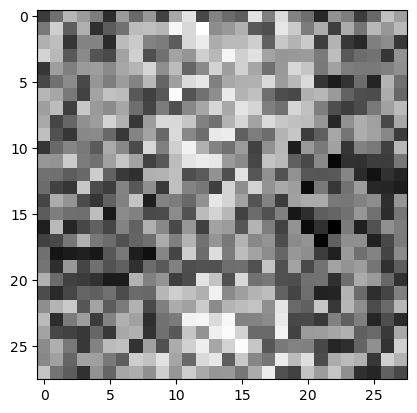

In [13]:
fit()
show_weights(model)

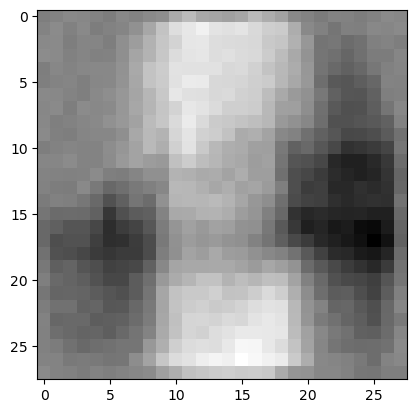

In [14]:
fit(1000)
show_weights(model)

Przy learning rate wynoszącym 0.1, przy jedynie 15 epokach nie mogę zawyażyć w naszym "filtrze" niczego ciekawego  
Po wykonaniu kolejnych 1000 epok możemy dostrzec zarysy jasnej sukienki i ciemnego buta.  
Im jaśniejszy piksel, tym większą wagę ma taki piksel. W związku z tym, piksele charakterystyczne dla rozpoznawania sukienki są jasne, a dla buta ciemne.

In [15]:
def acc(set, label):
    pred=model(set).squeeze().round()
    return torch.sum(pred==label).item()/label.size(0)*100


print(f"Train accuracy: {acc(train_set, train_labels):4.2f}%")
print(f"Test accuracy: {acc(test_set, test_labels):4.2f}%")


Train accuracy: 99.58%
Test accuracy: 99.30%


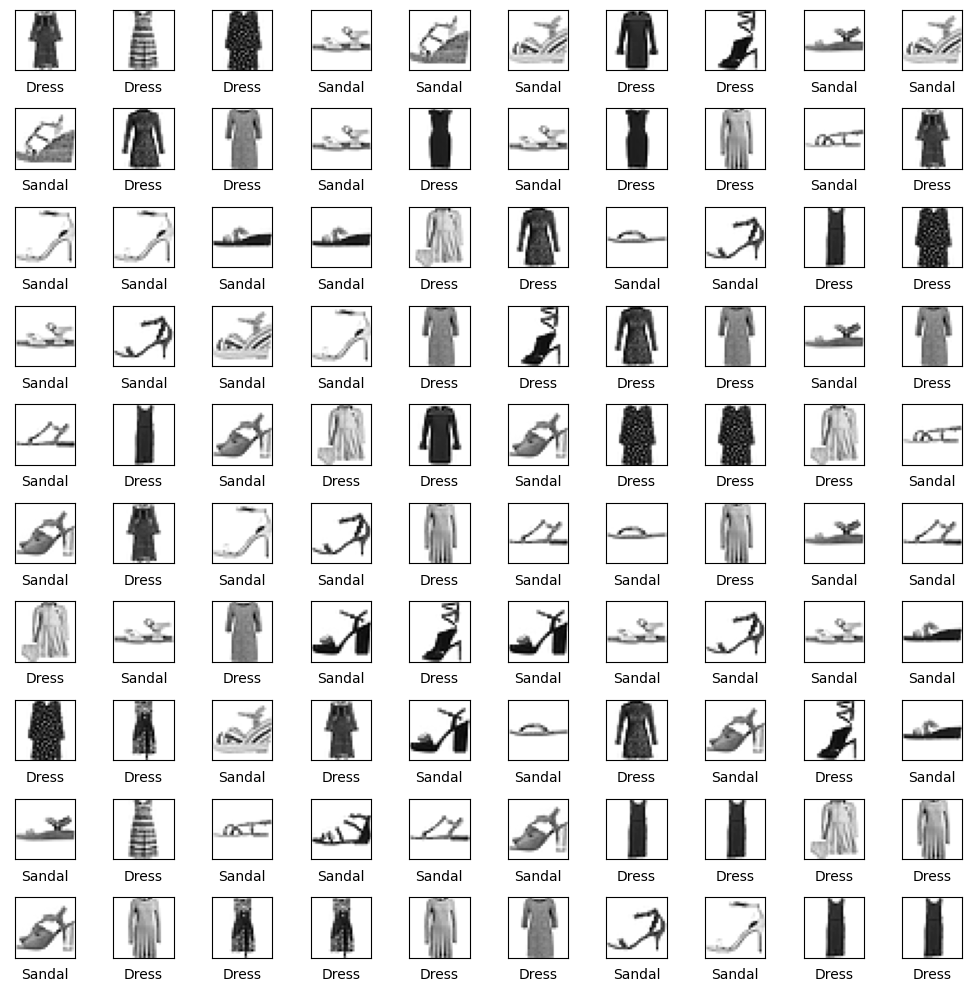

In [16]:
all_data = torch.cat((test_set, train_set), dim=0)
all_labels = torch.cat((test_labels, train_labels), dim=0)
all_data_subset25 = all_data[torch.randint(len(all_data), (25,))]

print_data(all_data_subset25, model=model)

Jak widać, w naszym przypadku model radzi sobie bardzo dobrze, zarówno na dancyh testowych jak i danych treningowych.

tensor(65)


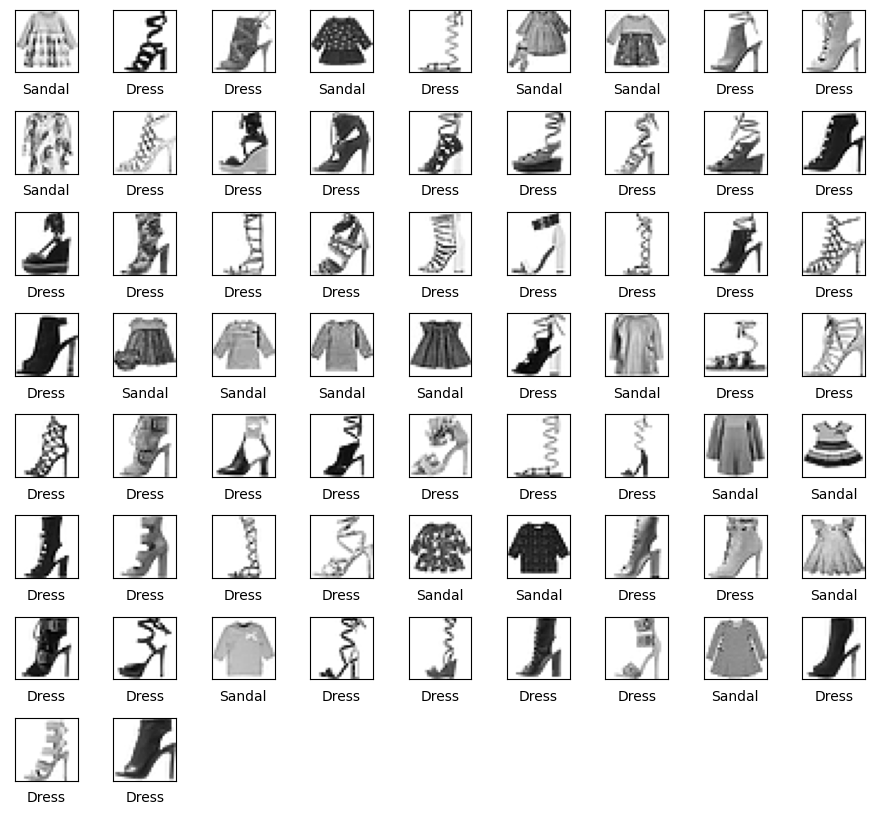

In [17]:
errors = ((model(all_data)>0.5).squeeze()!=(all_labels>0.5))
print(torch.sum(errors))
plt.figure(figsize=(9, 9))
for ix, error in enumerate(all_data[errors]):
    plt.subplot(9,9,ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(error.unflatten(dim=0, sizes=(28,28)), cmap=plt.cm.binary)
    plt.xlabel(classes[model(error)>0.5])
plt.tight_layout(pad=1)
plt.show()

Z ciekawości sprawdziłem na jakich przypadkach mylił się nasz model :-)

W przypadku tego zdaania nie skorzystałem za bardzo z pytorch lightning, ale mam nadzieję w nstępnych zadaniach z niego korzystać.  
W tym przapadku kolejnośc wykonywanych przezemnie zadań nie pozwalała mi jakoś logicznie zrozumieć i zaimplementować pytorch lightning...